# CTD LISST Comparison

Intro: A Sequoia Scientific LISST-200X is mounted on the CTD rosette during Pioneer MAB overturning cruises for comparison with the moored PRTSZ instruments on the OOI Coastal Surface Moorings. Questionable data from the moorings shortly after deployment in Spring 2025, prompted comparison and identification of a similar issue in the CTD cast data. The CTD-mounted LISST data quality was improved with thorough cleaning and a new clean water background which resulted in lower background counts in most of the 36 detector bins. 

Issue: Whether the updated clean water background can be reasonably used in processing of the first 20 casts of the Pioneer-21 Leg 1 cruise (AR87a) has not yet been confirmed, despite processing showing reasonable beam attenuation and optical transmission measurements.

Purpose: Compare LISST data collected during CTD casts with beam attenuation from the CTD transmissometer for data quality validation. Processed LISST data using the first clean water background of the cruise (high background counts, negative beam attenuation) and the second clean water background taken mid-cruise (low background counts, positive beam attenuation) will be compared.

#### Import modules used in analysis

In [1]:
from os import path
import glob
import re

import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
# from ioos_qc.qartod import gross_range_test # guessing at this

#### Load data into workspace
Load processed CSV data files from the LISST-200X mounted on the CTD rosette for Cast 005 from AR87a. 

In [2]:
# Load LISST CSV column names from json containing column headers
headers = pd.read_json("./inst_headers/lisst_hdr.json", typ='series', orient='records')
csvhdr = headers.iloc[0]
aschdr = headers.iloc[1]

In [3]:
# Define functions
def load_lisst(castnum, csvhdr):
    # Define paths to data
    lisst_path = "D:/LISST_PRTSZ/Pioneer21_AR87_PRTSZ_data"
    onboard_path = f"AR87a_CAST{castnum}_*/*.csv"
    # Load LISST data processed with onboard clean water background
    for f in glob.glob(path.join(lisst_path, onboard_path)):
        # Find the Julian date-time string from the file name with regex
        filename_base = re.findall("I[0-9]{7}", f)
        lisst_onboard = pd.read_csv(f, names=csvhdr)
        try: print(lisst_onboard.head(1)) 
        except: print("No onboard LISST data")
        # Load LISST data processed with updated clean water background
        reproc_path = f"Processed_Data_for_QC/20250404_Reprocessed/{re.sub("I", "L", filename_base[0])}*.csv"
        for f in glob.glob(path.join(lisst_path, reproc_path)):
            lisst_reproc = pd.read_csv(f, names=csvhdr)
        try: print(lisst_reproc.head(1)) 
        except: print("No reprocessed LISST data")
    return lisst_onboard, lisst_reproc

def load_ctd_ascii(castnum, aschdr):
    # Define path to data
    ctd_inst_path = f"D:/general*/AR87a_CTD_Casts/ctd/process/*_{castnum}.asc"
    # Load transmissometer data
    for f in glob.glob(ctd_inst_path):
        ctd_inst = pd.read_csv(f, names=aschdr, sep=r"\s+", index_col=False,
                                skiprows=1, encoding="ascii",
                                encoding_errors="replace")
        try: print(ctd_inst.head(1))
        except: print("No CTD cast data")
    return ctd_inst

In [4]:
# Load data into workspace
lisst_onboard, lisst_reproc = load_lisst("005", csvhdr)
ctd_inst = load_ctd_ascii("005", aschdr) 

   volumecon1  volumecon2  volumecon3  volumecon4  volumecon5  volumecon6  \
0      0.0009       0.006      0.0178      0.0423      0.0562      0.0343   

   volumecon7  volumecon8  volumecon9  volumecon10  ...  rel_humidity  \
0      0.0137      0.0046      0.0019       0.0005  ...            30   

   acceler_x  acceler_y  acceler_z  rawpressure1  rawpressure2  ambient_light  \
0       2325       2624       2346             0         22405              6   

   ext_in3  optical_transmission  beam_attenuation  
0    0.011                 0.964             1.447  

[1 rows x 61 columns]
   volumecon1 volumecon2 volumecon3 volumecon4 volumecon5 volumecon6  \
0         0.0     0.0038     0.0122     0.0335     0.0551     0.0441   

  volumecon7 volumecon8 volumecon9 volumecon10  ... rel_humidity acceler_x  \
0     0.0250     0.0177     0.0185      0.0209  ...           30      2415   

  acceler_y acceler_z rawpressure1 rawpressure2 ambient_light ext_in3  \
0      2714      2436          

In [5]:
# Create LISST and CTD time vectors for Dataset coordinates
ctd_inst.insert(0,"time", pd.to_datetime(ctd_inst.TimeQ, utc=True, unit='s', origin='2000-01-01T00:00:00').values)
ctd_inst.set_index("time", drop=True, inplace=True)
print(ctd_inst.head(1))
lisst_time = pd.to_datetime(lisst_onboard[["year", "month", "day", "hour", "minute", "second"]], yearfirst=True, utc=True)
lisst_onboard.insert(0, "time", lisst_time.values)
lisst_onboard.set_index("time", drop=True, inplace=True)
print(lisst_onboard.head(1))
lisst_reproc.insert(0, "time", lisst_time.values)
lisst_reproc.set_index("time", drop=True, inplace=True)
print(lisst_reproc.head(1))

                         TimeQ   TimeS  DepSM  PrDM    T090C    T190C  \
time                                                                    
2025-03-31 00:47:43  796697263  41.989  2.978   3.0  20.9585  20.9622   

                        C0S/m     C1S/m    Sal00    Sal11  ...      V7  \
time                                                       ...           
2025-03-31 00:47:43  4.989167  5.025232  35.8017  36.0896  ...  0.2029   

                         V6  DepSM-2  Sal00-2  Sal11-2  Sbeox0ML/L     SvCM  \
time                                                                          
2025-03-31 00:47:43  0.0609    2.978  35.8018  36.0897      5.1136  1525.03   

                     Sigma-é00  Sigma-é11  Flag  
time                                             
2025-03-31 00:47:43     25.116    25.3343   0.0  

[1 rows x 28 columns]
                     volumecon1  volumecon2  volumecon3  volumecon4  \
time                                                                  
2025

In [ ]:
# Convert data frames to xarray for easy manipulation
ctd_inst = xr.Dataset.from_dataframe(ctd_inst)
lisst_onboard = xr.Dataset.from_dataframe(lisst_onboard)
lisst_reproc = xr.Dataset.from_dataframe(lisst_reproc)

In [25]:
# Interpolate optical transmission onto common time coordinates
start_dt = ctd_inst.time[0].values
end_dt = ctd_inst.time[-1].values
time_coord = pd.date_range(start=start_dt, end=end_dt, freq="1s")
ctd_interp = ctd_inst.interp(time=time_coord)
lisst_onboard_interp = lisst_onboard.interp(time=time_coord)
lisst_reproc_interp = lisst_reproc.interp(time=time_coord)

#### Plot Transmissometer and LISST data

2 plots:<ul>
    <li> Depth profiles of Transmissometer and LISST data with 2 different clean water backgrounds
    <li> Difference between each pair: The data cannot easily be interpolated onto a common depth coordinate because the depths are not monotonically increasing or decreasing but they can be interpolated onto a common time coordinate.
    <ul>
        <li> Transmissometer and original LISST
        <li> Transmissometer and updated LISST
        <li> Original LISST and updated LISST

In [ ]:
# Get CTD Transmissometer data
ctd_transmission = ctd_inst["CStarTr0"].values
ctd_beamatten = ctd_inst["CStarAt0"].values
ctd_depth = ctd_inst["DepSM"].values

In [ ]:
# Get onboard processed LISST data - change to new units for optical transmission
onboard_transmission = lisst_onboard["optical_transmission"]*100
onboard_beamatten = lisst_onboard["beam_attenuation"]
lisst_depth = lisst_onboard["depth"].values

In [40]:
# Get reprocessed LISST data - change to new units for optical transmission
reproc_transmission = lisst_reproc["optical_transmission"]*100
reproc_beamatten = lisst_reproc["beam_attenuation"].astype(float)
# lisst_depth2 = lisst_reproc["depth"]

In [62]:
# Evaluate differences between transmission percentages
ctd_onboard_diff = ctd_interp.CStarTr0 - lisst_onboard_interp.optical_transmission*100
ctd_reproc_diff = ctd_interp.CStarTr0 - lisst_reproc_interp.optical_transmission*100
onboard_reproc_diff = 100*(lisst_onboard_interp.optical_transmission - lisst_reproc_interp.optical_transmission)

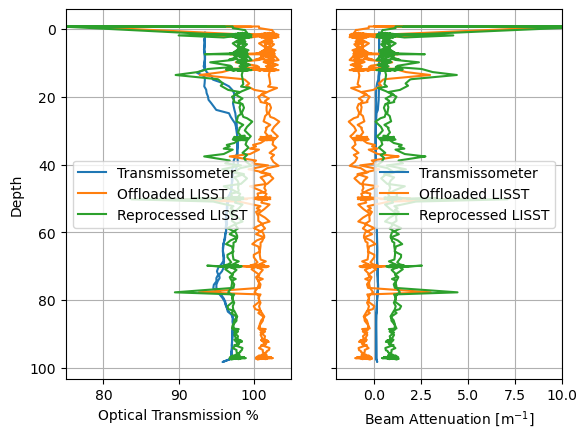

In [51]:
# Plot water column profiles
fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].plot(ctd_transmission, ctd_depth, label="Transmissometer")
axs[0].plot(onboard_transmission, lisst_depth, label="Offloaded LISST")
axs[0].plot(reproc_transmission, lisst_depth, label="Reprocessed LISST")
axs[0].invert_yaxis()
axs[0].set_ylabel("Depth")
axs[0].set_xlabel("Optical Transmission %")
axs[0].set_xlim([75, 105])
axs[0].legend()
axs[0].grid()

axs[1].plot(ctd_beamatten, ctd_depth, label="Transmissometer")
axs[1].plot(onboard_beamatten, lisst_depth, label="Offloaded LISST")
axs[1].plot(reproc_beamatten, lisst_depth, label="Reprocessed LISST")
axs[1].set_xlabel("Beam Attenuation [m$^{-1}$]")
axs[1].set_xlim([-2,10])
axs[1].legend()
axs[1].grid()

Text(0, 0.5, 'Optical Transmission\nDifference [%]')

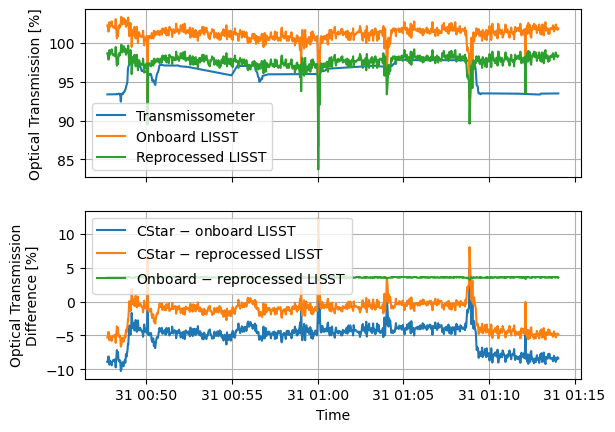

In [63]:
# Plot timeseries on same axes with difference between interpolated values
fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(ctd_interp.time, ctd_interp.CStarTr0, label="Transmissometer")
axs[0].plot(lisst_onboard_interp.time, lisst_onboard_interp.optical_transmission*100, label="Onboard LISST")
axs[0].plot(lisst_reproc_interp.time, lisst_reproc_interp.optical_transmission*100, label="Reprocessed LISST")
axs[0].grid()
axs[0].legend()
axs[0].set_ylabel("Optical Transmission [%]")

axs[1].plot(ctd_interp.time, ctd_onboard_diff, label="CStar $-$ onboard LISST")
axs[1].plot(ctd_interp.time, ctd_reproc_diff, label="CStar $-$ reprocessed LISST")
axs[1].plot(ctd_interp.time, onboard_reproc_diff, label="Onboard $-$ reprocessed LISST")
axs[1].grid()
axs[1].legend()
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Optical Transmission\nDifference [%]")

#### Evaluate quality tests on LISST data
The recommended QC procedure for optical transmission from Sequoia Scientific is encapsulated by running the IOOS QARTOD gross range test with both "fail" and "of interest/suspect" spans coming from the instrument manual. Other parameters are QC'ed with a gross range test which checks for values that fall within the vendor-defined instrument limits.

#### Plot profiles of total volume concentration
Using the data flags derived from optical transmission, we will plot total volume concentration, aka the sum of the individual volume concentration bins, for data that passes the quality tests. Suspect points will be plotted in yellow (for "caution").